https://keras.io/guides/functional_api/
https://pyimagesearch.com/2019/02/04/keras-multiple-inputs-and-mixed-data/

https://neptune.ai/blog/transfer-learning-guide-examples-for-images-and-text-in-keras#:~:text=%60include_top%3DFalse%60%20means%20that,is%20important%20for%20feature%20extraction.

Keras is able to handle multiple inputs (and even multiple outputs) via its functional API.



# Imports

In [1]:
import pandas as pd
import numpy as np
import os
import tensorflow as tf

# Preprocessing
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import nltk

# Preprocess features
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
nltk.download('stopwords')

# Preprocess targets
from sklearn.preprocessing import MinMaxScaler

#LSTM for regression
from keras.models import Sequential
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, concatenate
from tensorflow.keras.models import Model

# Evaluation
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error

# Visulization
from tensorflow.keras.utils import plot_model
import matplotlib.pyplot as plt

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


2023-06-28 10:35:16.325607: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/leamayer/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Data Loading

In [2]:
# Select Target Dataset

target_file = "CAvideos_12.csv"

df_target = pd.read_csv("../Data/processed_data/"+target_file)
df_target = df_target.dropna()

df_target = df_target [["channel_title","tags","description","views"]]

df_target["views"] = df_target["views"].astype(int)

# Create Source Data Set

folder_path = "../Data/processed_data"  # Path to processed df
iterator = 0
frames = []

# Iterate over files in the folder
for file_name in os.listdir(folder_path):

    if file_name.endswith('.csv') and file_name != target_file:  # Process only CSV files

        df = pd.read_csv("../Data/processed_data/"+file_name)
        df = df.dropna()

        df = df [["channel_title","tags","description","views"]]

        df["views"] = df["views"].astype(int)

        frames.append(df)

df_source = pd.concat(frames)

print(f">>> Created target df ({len(df_target)}) and source df ({len(df_source)})")

>>> Created target df (6039) and source df (111959)


In [3]:
# Select subset

df_target = df_target [:10000]

df_source = df_source [:10000]

In [4]:
# Loas features and targets

feature_df = df_source [["channel_title","tags","description"]]  # Text data as numpy list
targets = df_source["views"].to_numpy()  # Target data as numpy list


## Preprocessing

### Normalize Targets

In [5]:
# Normalizing the target values with the min-max normalization

scaler = MinMaxScaler()
normalized_targets = scaler.fit_transform(targets.reshape(-1, 1)).flatten()

print(f">>> Range from original targets ({targets.min()};{targets.max()}) has been normalized ({normalized_targets.min()};{normalized_targets.max()})")

>>> Range from original targets (1141;225211923) has been normalized (0.0;1.0)


### Image Preprocessing

### Apply Stemmer and Remove Stopwords from Text Features

In [6]:
# Add content speficic stopwords by select the top N words with the highest TF-IDF scores as potential stopwords

def get_content_stopwords(texts):
    
    vectorizer = TfidfVectorizer() # TfidfVectorizer object from sklearn

    tfidf_matrix = vectorizer.fit_transform(texts) 

    feature_names = vectorizer.get_feature_names_out()

    avg_tfidf_scores = tfidf_matrix.mean(axis=0).tolist()[0] # Get average TF-IDF score for each word

    word_scores = list(zip(feature_names, avg_tfidf_scores))

    word_scores.sort(key=lambda x: x[1], reverse=True) # Sort the word_scores in descending order

    N = 250 # Number of stopwords to select
    stopwords_content = [word for word, score in word_scores[:N]] # Potential stopwords

    print(f">>> {len(stopwords_content)} content specific stopwords are identified")

    return stopwords_content

In [7]:
# Define stemmer and stopwords

def get_stopwords(texts):

    # Stopwords
    stop_words_nlkt = set(stopwords.words('english'))

    # add contect speficic stopwords 
    original_stopword_len = len(stop_words_nlkt)

    stop_words = stop_words_nlkt.copy()

    stop_words |= set(get_content_stopwords(texts)) # Add the additional wikipedia specific stopwords

    merged_stopword_len = len(stop_words)

    print(f">>> {merged_stopword_len-original_stopword_len} additional stopwords have been added to the nlkt stopwords list")

    return stop_words

In [8]:
# Get Stemmer
stemmer = SnowballStemmer('english')
feature_df_preprocessed = pd.DataFrame()


for feature in feature_df:

    print(f"\n--- Preprocessing {feature} feature ---\n")

    texts = feature_df[feature].to_numpy()

    # Remove numbers and singel characters

    texts_preprocessed = [' '.join([word for word in text.split() if not word.isnumeric()]) for text in texts] # Remove numbers
    texts_preprocessed = [' '.join([word for word in text.split() if not len(word) > 1]) for text in texts] # Remove words with one character

    print(">>> Numbers and words with only one character are removed")

    # Get Stopwords
    stop_words = get_stopwords(texts)

    # Remove stop words from the text data and apply stemmer

    texts_preprocessed = [' '.join([stemmer.stem(word) for word in text.split() if word.lower() not in stop_words]) for text in texts]

    feature_df_preprocessed[feature] = texts_preprocessed

    print(">>> The Stemmer and the Stopword Removal are applied f.e.:\n")

    print (texts[5]) # show example
    print (texts_preprocessed[5])


--- Preprocessing channel_title feature ---

>>> Numbers and words with only one character are removed
>>> 250 content specific stopwords are identified
>>> 239 additional stopwords have been added to the nlkt stopwords list
>>> The Stemmer and the Stopword Removal are applied f.e.:

DramaAlert


--- Preprocessing tags feature ---

>>> Numbers and words with only one character are removed
>>> 250 content specific stopwords are identified
>>> 225 additional stopwords have been added to the nlkt stopwords list
>>> The Stemmer and the Stopword Removal are applied f.e.:

#DramaAlert|"Drama"|"Alert"|"DramaAlert"|"keemstar"|"youtube news"|"jake paul"|"team 10"|"alissa violet"|"cheated"|"logan paul"|"logan paul alissa violet"|"jake paul alissa violet"|"Martinez Twins"|"left team 10"|"faze banks"|"erika costell"
#dramaalert|"drama"|"alert"|"dramaalert"|"keemstar"|"youtub news"|"jak paul"|"team 10"|"alissa violet"|"cheated"|"logan paul"|"logan alissa violet"|"jak alissa violet"|"martinez twins

### Tokenize and Split the Text Data

In [9]:
# Tokenize the text data
def tokenize (texts):
    
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(texts)
    sequences = tokenizer.texts_to_sequences(texts)

    # Vocabulary size
    vocab_size = len(tokenizer.word_index) + 1

    # Pad sequences to a fixed length
    max_sequence_length = 100
    padded_sequences = pad_sequences(sequences, maxlen=max_sequence_length)

    return padded_sequences, vocab_size, max_sequence_length

In [10]:
# Split the data into training and validation sets
def train_val_test_split(padded_sequences):
    
    train_texts, val_texts = train_test_split( padded_sequences, test_size=0.2, random_state=42) # train-validation split with validation size of 20%
    train_texts, test_texts = train_test_split( train_texts, test_size=0.125, random_state=42) # train-test split with test size of 10%

    print(f">>> Text shape train: {train_texts.shape} val: {val_texts.shape} test: {test_texts.shape}")

    return train_texts, val_texts, test_texts

In [11]:

# Split target data

print(f"\n--- Splitting Target Data ---\n")

train_targets, val_targets = train_test_split( normalized_targets, test_size=0.2, random_state=42) # train-validation split with validation size of 20%
train_targets, test_targets = train_test_split( train_targets, test_size=0.125, random_state=42) # train-test split with test size of 10%
print(f">>> Target shape train: {train_targets.shape} val: {val_targets.shape} test: {test_targets.shape}")


# Split feature data featurewise

split_names = ["train_texts", "val_texts", "test_texts"]
vocab_list = []

for feature in feature_df_preprocessed:
    
    print(f"\n--- Tokenizing and Splitting {feature} feature ---\n")

    texts = feature_df_preprocessed[feature].to_numpy()

    return_values = tokenize(texts)

    padded_sequences = return_values[0]

    vocab_list.append(return_values[1])

    max_sequence_length = return_values[2]

    feature_df_preprocessed[feature] = padded_sequences

    split_list = train_val_test_split(padded_sequences)

    iterator = 0

    print(f">>> The Feature Splits are saved under the following names:")

    for split in split_list:
        variable_name = split_names[iterator]+"_"+feature
        print(variable_name)
        exec(variable_name + " = split")
        iterator+=1


--- Splitting Target Data ---

>>> Target shape train: (7000,) val: (2000,) test: (1000,)

--- Tokenizing and Splitting channel_title feature ---

>>> Text shape train: (7000, 100) val: (2000, 100) test: (1000, 100)
>>> The Feature Splits are saved under the following names:
train_texts_channel_title
val_texts_channel_title
test_texts_channel_title

--- Tokenizing and Splitting tags feature ---

>>> Text shape train: (7000, 100) val: (2000, 100) test: (1000, 100)
>>> The Feature Splits are saved under the following names:
train_texts_tags
val_texts_tags
test_texts_tags

--- Tokenizing and Splitting description feature ---

>>> Text shape train: (7000, 100) val: (2000, 100) test: (1000, 100)
>>> The Feature Splits are saved under the following names:
train_texts_description
val_texts_description
test_texts_description


# Model Training

In [13]:
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional

# Define the LSTM model with three text inputs
input1 = Input(shape=(max_sequence_length,))
input2 = Input(shape=(max_sequence_length,))
input3 = Input(shape=(max_sequence_length,))

# Define layers
embedding = Embedding(sum(vocab_list), 100)
lstm = Bidirectional(LSTM(150, return_sequences=True))
lstm_2 = Bidirectional(LSTM(150))
dense = Dense(6, activation='relu')
dense_2 = Dense(1, activation='sigmoid')

# Apply Layers to input
embedded1 = embedding(input1)
embedded2 = embedding(input2)
embedded3 = embedding(input3)
lstm1 = lstm(embedded1)
lstm2 = lstm(embedded2)
lstm3 = lstm(embedded3)
lstm1 = lstm_2(lstm1)
lstm2 = lstm_2(lstm2)
lstm3 = lstm_2(lstm3)
concatenated = concatenate([lstm1, lstm2, lstm3])
output_1 = dense(concatenated)
output_2 = dense_2(output_1)

model = Model(inputs=[input1, input2, input3], outputs=output_2)
model.compile(loss='mean_squared_error', optimizer='adam')

model.summary()

2023-06-28 10:39:28.398792: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 100)]        0           []                               
                                                                                                  
 input_5 (InputLayer)           [(None, 100)]        0           []                               
                                                                                                  
 input_6 (InputLayer)           [(None, 100)]        0           []                               
                                                                                                  
 embedding_1 (Embedding)        (None, 100, 100)     9615400     ['input_4[0][0]',                
                                                                  'input_5[0][0]',            


Es wurden einige Versuche durchgeführt, um die Leistung unserer neuronalen Netzwerke zu verbessern. Dabei wurden verschiedene Aktivierungsfunktionen wie Softmax, ReLU und lineare Aktivierung ausprobiert. Ebenso wurd versucht eine Normalisierungsschichten wie Batch-Normalisierung und Layer-Normalisierung zu implementieren. Des Weiteren wurde ein zweites LSTM und eine zweite Dense-Layers iim Modelle getestet. Keine diese Maßnahmen konnte eine signifikanten Verbesserungen hervorbringen und haben im Gegenteil den Loss vergößert. 

In [16]:
# Define the LSTM model with three text inputs
input1 = Input(shape=(max_sequence_length,))
input2 = Input(shape=(max_sequence_length,))
input3 = Input(shape=(max_sequence_length,))

# Define layers
embedding = Embedding(sum(vocab_list), 100)
lstm = LSTM(64)
dense = Dense(1, activation='linear')

# Apply Layers to input
embedded1 = embedding(input1)
embedded2 = embedding(input2)
embedded3 = embedding(input3)
lstm1 = lstm(embedded1)
lstm2 = lstm(embedded2)
lstm3 = lstm(embedded3)
concatenated = concatenate([lstm1, lstm2, lstm3])
output = dense(concatenated)

model = Model(inputs=[input1, input2, input3], outputs=output)
model.compile(loss='mean_squared_error', optimizer='adam')

model.summary()

2023-06-26 18:48:43.190466: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 100)]        0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 100)]        0           []                               
                                                                                                  
 input_3 (InputLayer)           [(None, 100)]        0           []                               
                                                                                                  
 embedding (Embedding)          (None, 100, 100)     9615400     ['input_1[0][0]',                
                                                                  'input_2[0][0]',            

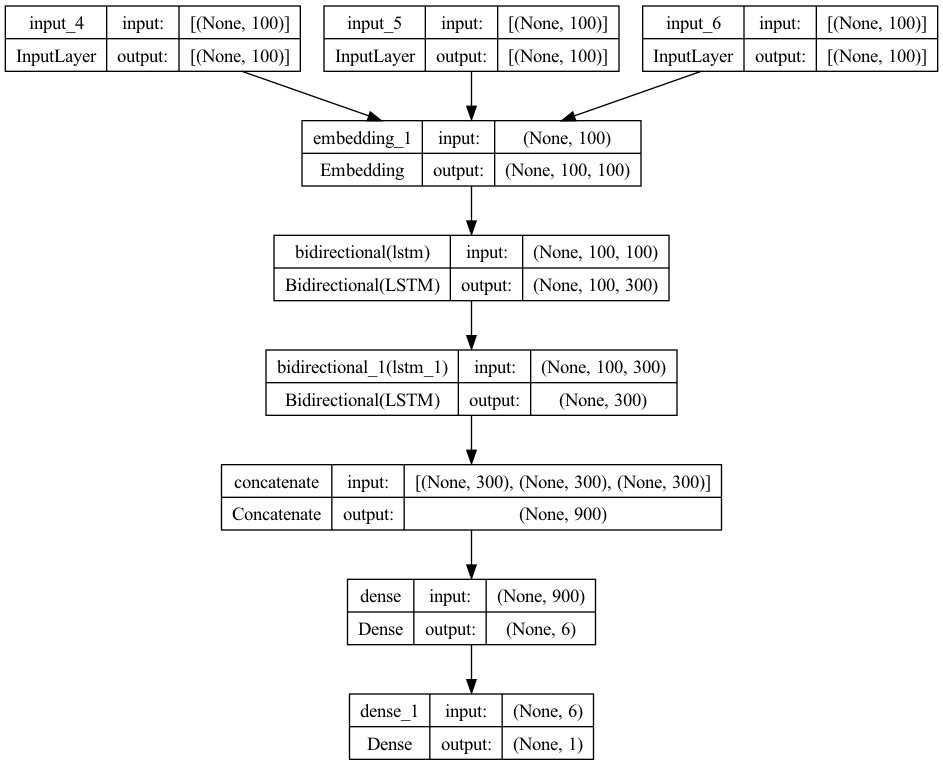

In [14]:
plot_model(model, show_shapes=True)

# Komplexität der Aufgabe beachten
# Return sequence True bei 2. LSTM

In [18]:
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard

callbacks = [
            EarlyStopping(patience = 10)#,
            #TensorBoard(log_dir=log_folder)
            ]

In [22]:
# Train the model
batch_size = 32
epochs = 10
history_three_features = model.fit([train_texts_channel_title, train_texts_tags, train_texts_description],
                                   train_targets,
                                   batch_size=batch_size,
                                   epochs=epochs,
                                   validation_data=([val_texts_channel_title, val_texts_tags, val_texts_description], val_targets), 
                                   callbacks=callbacks)

# https://stackoverflow.com/questions/65514944/tensorflow-embeddings-invalidargumenterror-indices18-16-11905-is-not-in-0

Epoch 1/10
219/219 [==============================] - 148s 678ms/step - loss: 9.0663e-04 - val_loss: 0.0011
Epoch 2/10
219/219 [==============================] - 167s 762ms/step - loss: 9.0663e-04 - val_loss: 0.0011
Epoch 3/10
219/219 [==============================] - 174s 795ms/step - loss: 9.0663e-04 - val_loss: 0.0011
Epoch 4/10
219/219 [==============================] - 179s 819ms/step - loss: 9.0663e-04 - val_loss: 0.0011
Epoch 5/10
219/219 [==============================] - 175s 797ms/step - loss: 9.0663e-04 - val_loss: 0.0011
Epoch 6/10
219/219 [==============================] - 185s 843ms/step - loss: 9.0663e-04 - val_loss: 0.0011
Epoch 7/10
219/219 [==============================] - 188s 860ms/step - loss: 9.0663e-04 - val_loss: 0.0011
Epoch 8/10
219/219 [==============================] - 176s 802ms/step - loss: 9.0663e-04 - val_loss: 0.0011
Epoch 9/10
219/219 [==============================] - 173s 792ms/step - loss: 9.0663e-04 - val_loss: 0.0011
Epoch 10/10
219/219 [=======

## Hyperparameter Optimierung

ML Flow

## Save Model and Weights 

In [29]:
model.save('source_lstm_model.h5')
model.save_weights('source_lstm_model_weights.h5')

## Use Pretrained Model

In [30]:
from keras.layers import Input, Flatten, Dense

#Get back the convolutional part of a VGG network trained on ImageNet
model_pretrain = tf.keras.models.load_model('source_lstm_model.h5')
model_pretrain.load_weights('source_lstm_model_weights.h5')
model_pretrain.summary()

#model_pretrain.include_top = False
model_pretrain.trainable = False

#Use the generated model 
input1 = Input(shape=(max_sequence_length,))
input2 = Input(shape=(max_sequence_length,))
input3 = Input(shape=(max_sequence_length,))

#Add the fully-connected layers
#x = Flatten(name='flatten')(model_pretrain)
x = model_pretrain(inputs=[input1, input2, input3], training=False)
x = Dense(1, activation='linear')(x)

#Create your own model 
transfer_model = Model(inputs=[input1, input2, input3], outputs=x)

#In the summary, weights and layers from VGG part will be hidden, but they will be fit during the training
transfer_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 100)]        0           []                               
                                                                                                  
 input_5 (InputLayer)           [(None, 100)]        0           []                               
                                                                                                  
 input_6 (InputLayer)           [(None, 100)]        0           []                               
                                                                                                  
 embedding_1 (Embedding)        (None, 100, 100)     9615400     ['input_4[0][0]',                
                                                                  'input_5[0][0]',            

In [32]:
transfer_model.compile(loss='mean_squared_error', optimizer='adam')
transfer_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 100)]        0           []                               
                                                                                                  
 input_8 (InputLayer)           [(None, 100)]        0           []                               
                                                                                                  
 input_9 (InputLayer)           [(None, 100)]        0           []                               
                                                                                                  
 model (Functional)             (None, 1)            10463213    ['input_7[0][0]',                
                                                                  'input_8[0][0]',          

In [33]:
# Train the model
batch_size = 32
epochs = 20
history_transfer_model = transfer_model.fit([train_texts_channel_title, train_texts_tags, train_texts_description],
                                   train_targets,
                                   batch_size=batch_size,
                                   epochs=epochs,
                                   validation_data=([val_texts_channel_title, val_texts_tags, val_texts_description], val_targets))

Epoch 1/20
219/219 [==============================] - 57s 222ms/step - loss: 8.0970e-04 - val_loss: 9.9168e-04
Epoch 2/20
219/219 [==============================] - 49s 225ms/step - loss: 8.0715e-04 - val_loss: 9.9088e-04
Epoch 3/20
219/219 [==============================] - 53s 242ms/step - loss: 8.0736e-04 - val_loss: 9.9264e-04
Epoch 4/20
219/219 [==============================] - 55s 252ms/step - loss: 8.0646e-04 - val_loss: 9.9144e-04
Epoch 5/20
219/219 [==============================] - 55s 252ms/step - loss: 8.0749e-04 - val_loss: 9.9396e-04
Epoch 6/20
219/219 [==============================] - 58s 266ms/step - loss: 8.0691e-04 - val_loss: 0.0010
Epoch 7/20
219/219 [==============================] - 56s 255ms/step - loss: 8.0867e-04 - val_loss: 9.9476e-04
Epoch 8/20
219/219 [==============================] - 57s 260ms/step - loss: 8.0678e-04 - val_loss: 9.9058e-04
Epoch 9/20
219/219 [==============================] - 56s 255ms/step - loss: 8.0610e-04 - val_loss: 9.9073e-04
Epoch

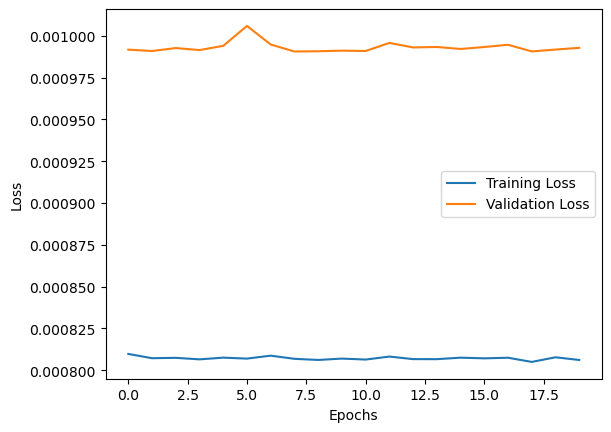

In [34]:
# Plot training and validation loss

# Plot the loss values
plt.plot(history_transfer_model.history['loss'], label='Training Loss')
plt.plot(history_transfer_model.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

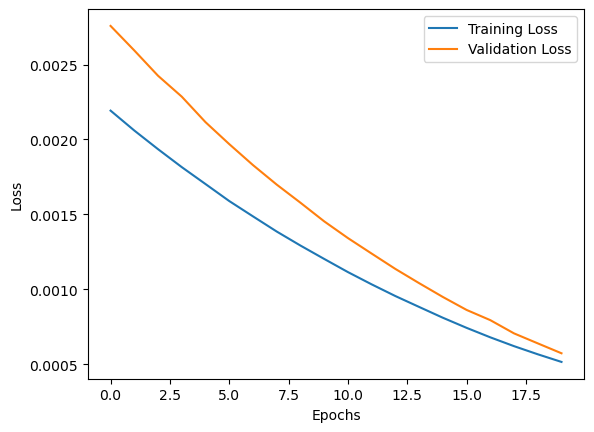

In [26]:
# Plot training and validation loss

# Plot the loss values
plt.plot(history_transfer_model.history['loss'], label='Training Loss')
plt.plot(history_transfer_model.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Singel input benchmark

In [ ]:
'''# Define the LSTM model
model = Sequential()
model.add(Embedding(vocab_size, 100, input_length=max_sequence_length))
model.add(LSTM(64))
model.add(Dense(1, activation='linear'))
model.compile(loss='mean_squared_error', optimizer='adam')'''

In [ ]:
'''# Train the model
batch_size = 32
epochs = 10
history = model.fit(train_texts, train_targets, batch_size=batch_size, epochs=epochs, validation_data=(val_texts, val_targets))'''

Epoch 1/10
701/701 [==============================] - 42s 58ms/step - loss: 5.7358e-04 - val_loss: 6.2133e-04
Epoch 2/10
701/701 [==============================] - 37s 52ms/step - loss: 4.2834e-04 - val_loss: 5.0082e-04
Epoch 3/10
701/701 [==============================] - 38s 55ms/step - loss: 3.2502e-04 - val_loss: 3.4616e-04
Epoch 4/10
701/701 [==============================] - 40s 57ms/step - loss: 2.4866e-04 - val_loss: 2.8923e-04
Epoch 5/10
701/701 [==============================] - 41s 58ms/step - loss: 2.1050e-04 - val_loss: 2.8746e-04
Epoch 6/10
701/701 [==============================] - 40s 58ms/step - loss: 2.0737e-04 - val_loss: 3.0628e-04
Epoch 7/10
701/701 [==============================] - 40s 58ms/step - loss: 2.1138e-04 - val_loss: 2.8668e-04
Epoch 8/10
701/701 [==============================] - 40s 58ms/step - loss: 1.8486e-04 - val_loss: 2.5614e-04
Epoch 9/10
701/701 [==============================] - 37s 52ms/step - loss: 1.8657e-04 - val_loss: 3.1524e-04
Epoch 10/1

# Model Evaluation

## Evaluatie Loss

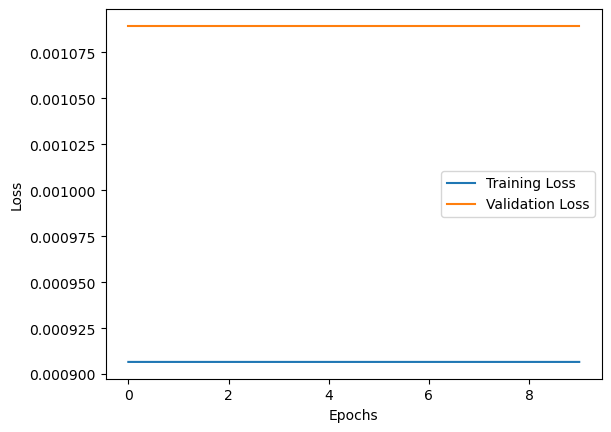

In [24]:
# Plot training and validation loss

# Plot the loss values
plt.plot(history_three_features.history['loss'], label='Training Loss')
plt.plot(history_three_features.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

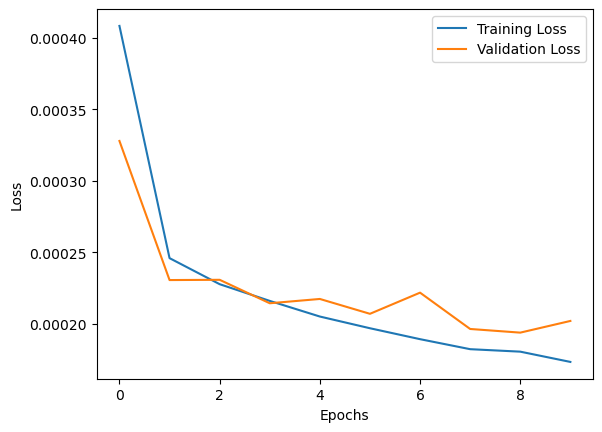

In [25]:
# Plot training and validation loss

# Plot the loss values
plt.plot(history_three_features.history['loss'], label='Training Loss')
plt.plot(history_three_features.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

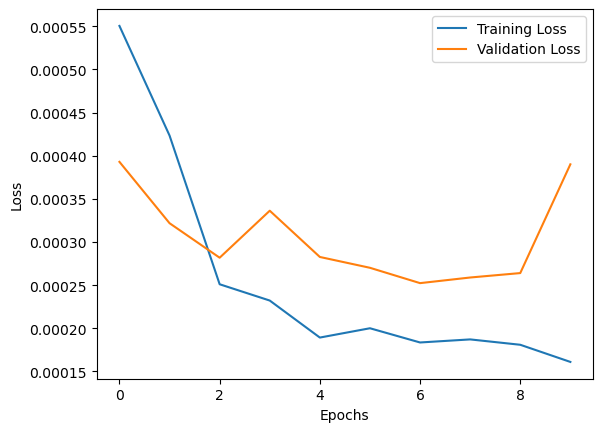

In [ ]:
# Plot training and validation loss

# Plot the loss values
plt.plot(history_three_features.history['loss'], label='Training Loss')
plt.plot(history_three_features.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Prediction

In [27]:
# Make predictions
pred = transfer_model.predict([test_texts_channel_title,test_texts_tags, test_texts_description])

# Convert normalized predictions back to original scale
original_pred = scaler.inverse_transform(pred.reshape(-1, 1)).flatten()
original_targets = scaler.inverse_transform(test_targets.reshape(-1, 1)).flatten()

# Evaluation metrics
mse = mean_squared_error(original_targets, original_pred)
mape = mean_absolute_percentage_error(original_targets, original_pred)
rmse = np.sqrt(mse)
print("Mean Squared Error (MSE):", mse)
print("Mean Absolute Percentage Error (MAPE):", mape)
print("Root Mean Squared Error (RMSE):", rmse)

350/350 [==============================] - 7s 18ms/step
Mean Squared Error (MSE): 32607389230929.125
Mean Absolute Percentage Error (MAPE): 6.8873711379637985
Root Mean Squared Error (RMSE): 5710288.016460214


In [35]:
# Make predictions
pred = model.predict([test_texts_channel_title,test_texts_tags, test_texts_description])

# Convert normalized predictions back to original scale
original_pred = scaler.inverse_transform(pred.reshape(-1, 1)).flatten()
original_targets = scaler.inverse_transform(test_targets.reshape(-1, 1)).flatten()

# Evaluation metrics
mse = mean_squared_error(original_targets, original_pred)
mape = mean_absolute_percentage_error(original_targets, original_pred)
rmse = np.sqrt(mse)
print("Mean Squared Error (MSE):", mse)
print("Mean Absolute Percentage Error (MAPE):", mape)
print("Root Mean Squared Error (RMSE):", rmse)

32/32 [==============================] - 5s 161ms/step
Mean Squared Error (MSE): 23254206999620.047
Mean Absolute Percentage Error (MAPE): 0.9882941960704634
Root Mean Squared Error (RMSE): 4822261.606302591


In [26]:
# Make predictions
pred = model.predict([test_texts_channel_title,test_texts_tags, test_texts_description])

# Convert normalized predictions back to original scale
original_pred = scaler.inverse_transform(pred.reshape(-1, 1)).flatten()
original_targets = scaler.inverse_transform(test_targets.reshape(-1, 1)).flatten()

# Evaluation metrics
mse = mean_squared_error(original_targets, original_pred)
mape = mean_absolute_percentage_error(original_targets, original_pred)
rmse = np.sqrt(mse)
print("Mean Squared Error (MSE):", mse)
print("Mean Absolute Percentage Error (MAPE):", mape)
print("Root Mean Squared Error (RMSE):", rmse)

350/350 [==============================] - 8s 22ms/step
Mean Squared Error (MSE): 32331973988614.17
Mean Absolute Percentage Error (MAPE): 5.770824016955864
Root Mean Squared Error (RMSE): 5686121.172522985


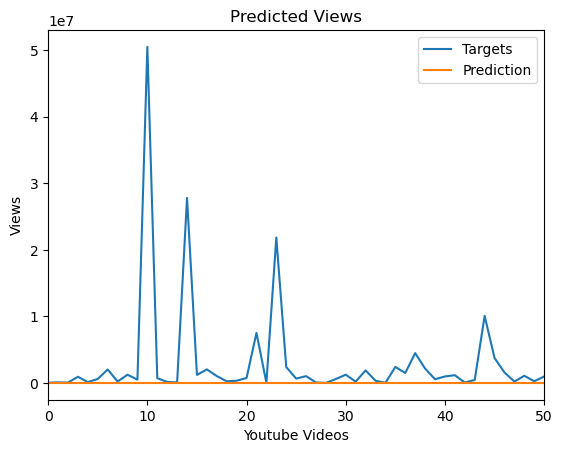

In [37]:
# Plotting
plt.plot(original_targets, label='Targets')
plt.plot(original_pred, label='Prediction')

# Add labels and title
plt.xlabel('Youtube Videos')
plt.ylabel('Views')
plt.title('Predicted Views')
plt.xlim((0, 50))

# Add legend
plt.legend()

# Show the plot
plt.show()

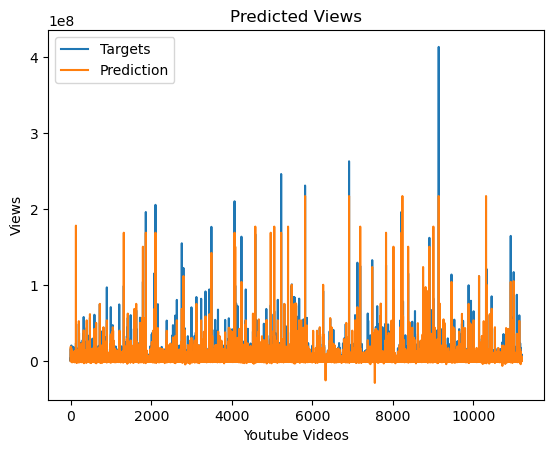

In [28]:
# Plotting
plt.plot(original_targets, label='Targets')
plt.plot(original_pred, label='Prediction')

# Add labels and title
plt.xlabel('Youtube Videos')
plt.ylabel('Views')
plt.title('Predicted Views')

# Add legend
plt.legend()

# Show the plot
plt.show()

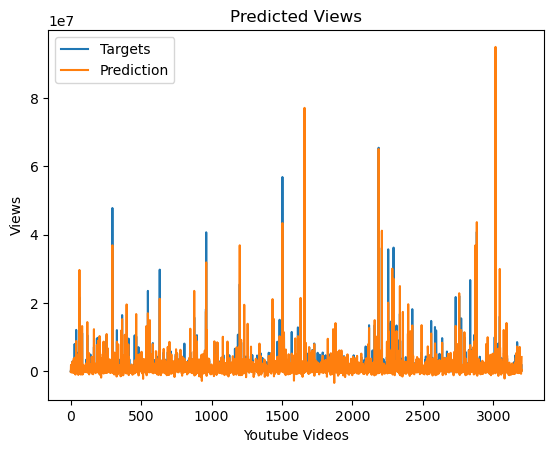

In [ ]:
# Plotting
plt.plot(original_targets, label='Targets')
plt.plot(original_pred, label='Prediction')

# Add labels and title
plt.xlabel('Youtube Videos')
plt.ylabel('Views')
plt.title('Predicted Views')

# Add legend
plt.legend()

# Show the plot
plt.show()

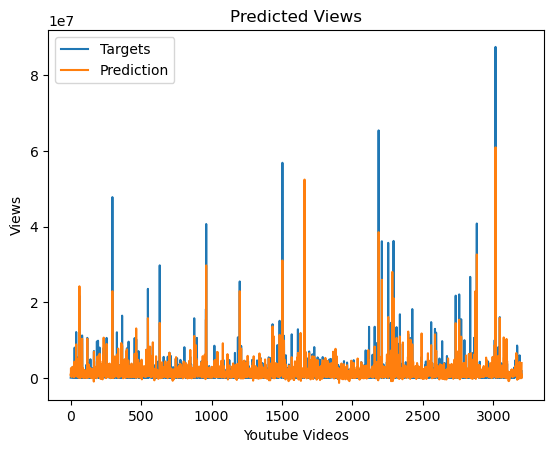

In [ ]:
# Plotting
plt.plot(original_targets, label='Targets')
plt.plot(original_pred, label='Prediction')

# Add labels and title
plt.xlabel('Youtube Videos')
plt.ylabel('Views')
plt.title('Predicted Views')

# Add legend
plt.legend()

# Show the plot
plt.show()